# YOLOv8 Tracking and Counting

---

Ultralytics YOLOv8 is the latest version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.



## Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on how to train YOLOv8 Tracking and Counting, concurrently.


## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLOv8
- Install ByteTrack
- Install Roboflow Supervision
- Tracking utils
- Load pre-trained YOLOv8 model
- Predict and annotate single frame
- Predict and annotate whole video

**Let's begin!**

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/root/Copilot/ByteTrack


## Load video

In [3]:
SOURCE_VIDEO_PATH = "videos/bdd/b1c9c847-3bda4659.mov"

In [23]:


import ultralytics
ultralytics.checks()
import numpy as np
print(np.__version__)
import yolox
print("yolox.__version__:", yolox.__version__)
import supervision
print("supervision.__version__:", supervision.__version__)

1.19.5
yolox.__version__: 0.1.0
supervision.__version__: 0.1.0


In [8]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass
from tqdm.notebook import tqdm

np.float = float   

@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [10]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [11]:
import sys
sys.executable

'/root/miniconda3/bin/python'

In [12]:
import numpy as np
np.__version__

'1.19.5'

## Tracking utils

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [13]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [14]:
# settings
MODEL = "models/yolov8x.pt"

In [15]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


## Predict and annotate single frame

In [16]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [0, 2, 3, 5, 7]


0: 384x640 2 persons, 2 bicycles, 7 cars, 1 truck, 10 traffic lights, 1 backpack, 121.8ms
Speed: 10.7ms preprocess, 121.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


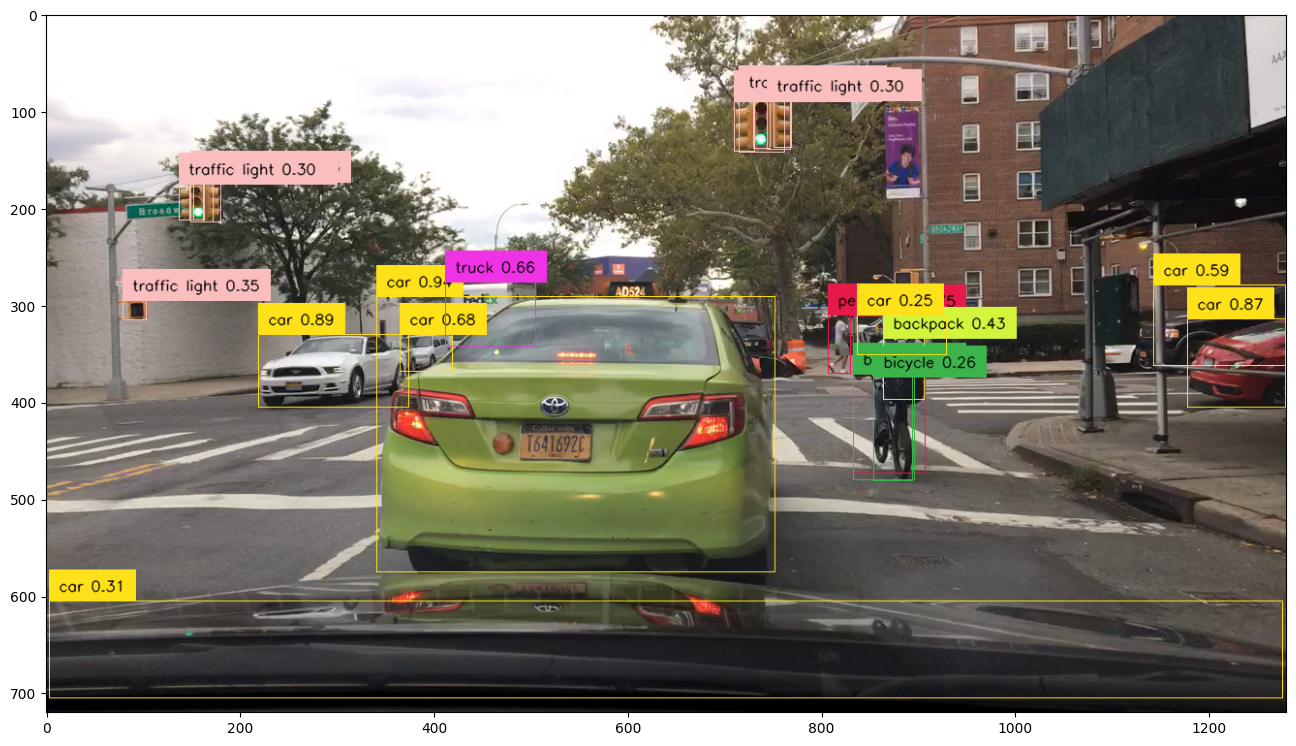

In [17]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=0.5)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

## Predict and annotate whole video

In [18]:
# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result.mp4"

In [19]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=29, total_frames=1208)

In [20]:
def write_mot_format(detections, frame_number, output_file):
    """
    Writes the detections in MOT format to the output file.

    Parameters:
    - detections: The detections for the current frame.
    - frame_number: The current frame number.
    - output_file: The file to which the MOT formatted output should be written.
    """
    with open(output_file, 'a') as f:
        for xyxy, confidence, class_id, tracker_id in detections:
            x, y, w, h = xyxy[0]  # Assuming detections.xyxy is a list of [x, y, w, h]
            line = f"{frame_number},{tracker_id},{x},{y},{w},{h},{confidence},{class_id},-1,-1\n"
            f.write(line)


In [22]:
MOT_OUTPUT_PATH = f"YOLOX_outputs/car_{SOURCE_VIDEO_PATH[0:-4]}.txt"

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=1, text_scale=0.5)
line_annotator = LineCounterAnnotator(thickness=2, text_thickness=1, text_scale=0.5)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    with open(MOT_OUTPUT_PATH, 'a') as f:
        for frame_number, frame in tqdm(enumerate(generator), total=video_info.total_frames):
            # model prediction on single frame and conversion to supervision Detections
            results = model(frame)
            detections = Detections(
                xyxy=results[0].boxes.xyxy.cpu().numpy(),
                confidence=results[0].boxes.conf.cpu().numpy(),
                class_id=results[0].boxes.cls.cpu().numpy().astype(int)
            )
            
            # filtering out detections with unwanted classes
            mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
            detections.filter(mask=mask, inplace=True)
            # tracking detections
            tracks = byte_tracker.update(
                output_results=detections2boxes(detections=detections),
                img_info=frame.shape,
                img_size=frame.shape
            )
            tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
            detections.tracker_id = np.array(tracker_id)
            # filtering out detections without trackers
            mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
            detections.filter(mask=mask, inplace=True)
            # format custom labels
            labels = [
                f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
                for _, confidence, class_id, tracker_id
                in detections
            ]
            # updating line counter
            line_counter.update(detections=detections)
            # annotate and display frame
            frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
            line_annotator.annotate(frame=frame, line_counter=line_counter)
            sink.write_frame(frame)
            for xyxy, confidence, class_id, tracker_id in detections:
                x, y, w, h = xyxy[0]  # Assuming detections.xyxy is a list of [x, y, w, h]
                line = f"{frame_number},{tracker_id},{x},{y},{w},{h},{confidence},{class_id},-1,-1\n"
                f.write(line)

  0%|          | 0/1208 [00:00<?, ?it/s]


0: 384x640 2 persons, 2 bicycles, 7 cars, 1 truck, 10 traffic lights, 1 backpack, 10.9ms
Speed: 20.8ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bicycle, 8 cars, 1 truck, 11 traffic lights, 1 backpack, 10.8ms
Speed: 1.6ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bicycle, 8 cars, 1 truck, 9 traffic lights, 1 backpack, 10.8ms
Speed: 1.5ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bicycle, 8 cars, 1 truck, 8 traffic lights, 1 backpack, 10.8ms
Speed: 1.5ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 bicycles, 8 cars, 1 truck, 8 traffic lights, 1 backpack, 10.8ms
Speed: 1.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 bicycles, 9 cars, 1 truck, 9 traffic lights, 

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.